# 3. Aprendizaje Supervisado 




In [1]:
### LIMPIEZA DE DATOS 
import numpy as np
import pandas as pd

###VISUALIZACION DEL MODELO

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb

## Modelos de Aprendizaje Supervisado

In [2]:
###DIVISION DE LOS DATOS----------------------------------------------- 

data= pd.read_csv("seleccion_variables_RF_bathandrooms.csv")


#Etiquetarlos datos en funcion de alto o bajo. 

mediana= 870000.0
data["precio_div"]= np.where(data["Price"]>=mediana, "1", "0" )#1 es caro Y 0 es barato 
#print(data.head(100))
data=data.replace(np.nan,"0")
print(data.groupby('precio_div').size())

precio_div
0    13381
1    13675
dtype: int64


In [3]:
# Hemos separado  el 70%

# dividir el data set de forma aleatoria 

p_train = 0.70 # Porcentaje de train.

data['is_train'] = np.random.uniform(0, 1, len(data)) <= p_train
train, test = data[data['is_train']==True], data[data['is_train']==False]
df = data.drop('is_train', 1)

print("Ejemplos usados para entrenar: ", len(train))
print("Ejemplos usados para test: ", len(test))


Ejemplos usados para entrenar:  18919
Ejemplos usados para test:  8137


### 1. GLM : Regresion Logística 

 hacer graficas 
  con y sin normalizar??


In [4]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [5]:
#TRAIN 
features = np.array(train[['Distance','Lattitude','Landsize','Bathroom']])
labels = np.array(train['precio_div'])

In [6]:
#TEST
features_t = np.array(test[['Distance','Lattitude','Landsize','Bathroom']])
labels_t = np.array(test['precio_div'])

In [7]:
# Create logistic regression model

model = linear_model.LogisticRegression()

#Train the model
model.fit(features, labels)#The first is a matrix of features, and the second is a matrix of class labels. 

LogisticRegression()

In [8]:
#Validacion del modelo

#predicion of the class
predictions_t= model.predict(features_t)
print(accuracy_score(labels_t, predictions_t))

0.6909180287575274


In [9]:
#Reporte de resultados del Modelo

print(classification_report(labels_t , predictions_t))

              precision    recall  f1-score   support

           0       0.67      0.72      0.70      4011
           1       0.71      0.66      0.68      4126

    accuracy                           0.69      8137
   macro avg       0.69      0.69      0.69      8137
weighted avg       0.69      0.69      0.69      8137



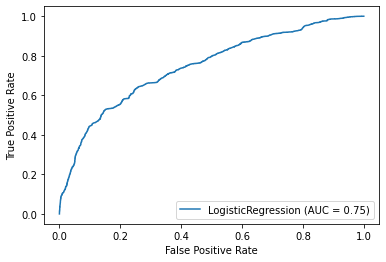

In [10]:
#dibujo de la Curva ROC

from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

rlog_disp = plot_roc_curve(model, features, labels)
plt.show()


### 2. K- NEAREST NEIGHBORS (KNN )



In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [12]:
# # SELECCION DE VARIABLES

X = train[['Distance','Lattitude','Landsize','Bathroom']].values
y = train['precio_div'].values

X_test=test[['Distance','Lattitude','Landsize','Bathroom']].values
y_test=test['precio_div'].values
 

In [13]:
#NORMALIZACION
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)


In [14]:

#encontrar la mejor k 

#best_k=0
#best_score=0
#neighbors=range(1,10,2)#considerara min_k=1, max_k=25, solo odd numbers 
#for k in neighbors:
    #knn=KNeighborsClassifier(n_neighbors=k) #instantiante classifier
    #knn.fit(X, y )# fit model 
    #knn_y_pred= knn.predict(X_test)
    
    #we will consider the optimal k to be the k that produce the highest f1 score
    #f1 = metrics.f1_score(y_test, knn_y_pred, pos_label= 0)
    #if f1> best_score:
        #best_k= k 
        #best_score =f1
        

#instantiate the classifier with the optimal k, fir the model and make predictions
#knn=  KNeighborsClassifier(n_neighbors=best_k) 
#knn.fit(X, y )
#knn_y_pred= knn.predict(X_test)



([<matplotlib.axis.XTick at 0x7f8a9ecdb280>,
 <a list of 5 Text major ticklabel objects>)

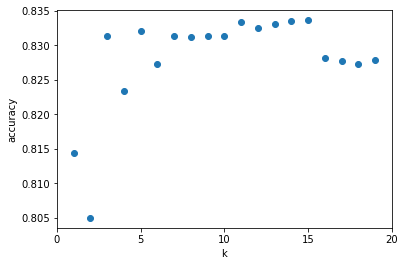

In [15]:
#ELEGIR EL MEJOR K 

k_range = range(1, 20)
scores = []
for k in k_range:
     knn = KNeighborsClassifier(n_neighbors = k)
     knn.fit(X, y)
     scores.append(knn.score(X_test, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

In [33]:
#Hiperparametros-
n_neighbors = 3
#algorithm='brute'
#p=1
weights='distance'# uniforme ( todos los puntos son iguales )
#n_jobs=-1

classifier = KNeighborsClassifier(n_neighbors)

# #Train the classifier
classifier.fit(X,y)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(classifier.score(X, y)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.90
Accuracy of K-NN classifier on test set: 0.83


In [27]:
#ENTRENAR EL MODELO

#Hiperparametros-
n_neighbors = 5
#algorithm='brute'
#p=1
weights='distance'# uniforme ( todos los puntos son iguales )
#n_jobs=-1

classifier = KNeighborsClassifier(n_neighbors)

# #Train the classifier
classifier.fit(X,y)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(classifier.score(X, y)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.88
Accuracy of K-NN classifier on test set: 0.83


In [31]:
#PRECISION DEL MODELO
pred = classifier.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[3265  746]
 [ 608 3518]]
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      4011
           1       0.83      0.85      0.84      4126

    accuracy                           0.83      8137
   macro avg       0.83      0.83      0.83      8137
weighted avg       0.83      0.83      0.83      8137



In [26]:

#ENTRENAR EL MODELO

#Hiperparametros-
n_neighbors = 11
#algorithm='brute'
#p=1
weights='distance'# uniforme ( todos los puntos son iguales )
#n_jobs=-1

classifier = KNeighborsClassifier(n_neighbors)

# #Train the classifier
classifier.fit(X,y)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(classifier.score(X, y)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.86
Accuracy of K-NN classifier on test set: 0.83


In [29]:
#PRECISION DEL MODELO
pred = classifier.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[3265  746]
 [ 608 3518]]
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      4011
           1       0.83      0.85      0.84      4126

    accuracy                           0.83      8137
   macro avg       0.83      0.83      0.83      8137
weighted avg       0.83      0.83      0.83      8137



In [28]:

#ENTRENAR EL MODELO

#Hiperparametros-
n_neighbors = 15
#algorithm='brute'
#p=1
weights='distance'# uniforme ( todos los puntos son iguales )
#n_jobs=-1

classifier = KNeighborsClassifier(n_neighbors)

# #Train the classifier
classifier.fit(X,y)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(classifier.score(X, y)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.85
Accuracy of K-NN classifier on test set: 0.83


In [30]:
#PRECISION DEL MODELO
pred = classifier.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[3265  746]
 [ 608 3518]]
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      4011
           1       0.83      0.85      0.84      4126

    accuracy                           0.83      8137
   macro avg       0.83      0.83      0.83      8137
weighted avg       0.83      0.83      0.83      8137



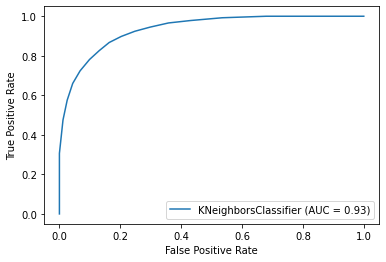

In [32]:
#Pintar curva ROC
Knn_disp = plot_roc_curve(classifier, X, y)
plt.show()

### 3. SVM 


Primero sin normalizar y despues normalizando 
probar los difrentes kernels 

In [34]:
from sklearn.svm import SVC
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

In [35]:
X = train[['Distance','Lattitude','Landsize','Bathroom']].values
y = train['precio_div'].values

X_test=test[['Distance','Lattitude','Landsize','Bathroom']].values
y_test=test['precio_div'].values

Kernel Lineal 

In [21]:
#classifier = SVC(kernel = "linear", C = 2)
#classifier.fit(X, y) 
#print(classifier.predict(X_test))
#print("Kernel lineal", classifier.score(X_test, Y_test))

Kernel Polinómico

In [22]:
#classifier = SVC(kernel = "poly",degree= 2, C = 2)
#classifier.fit(X, y) 
#print(classifier.predict(X_test))
#print("Kernel polinómico", classifier.score(X_test, Y_test))

Kernel RBF

In [36]:
classifier = SVC(kernel = "rbf", gamma = 0.3, C = 2)
classifier.fit(X, y) 
#print(classifier.predict(X_test))
print("Kernel rbf", classifier.score(X_test, y_test))

Kernel rbf 0.7252058498218017


Normalizando 

In [37]:
#NORMALIZACION

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

classifier = SVC(kernel = "rbf", gamma = 0.3, C = 2)
classifier.fit(X, y) 
#print(classifier.predict(X_test))
print(classifier.score(X_test, y_test))

0.7753471795502028


In [39]:
#from sklearn.model_selection import GridSearchCV

#define the hyperparameters we ant to tune 
#param_grid={
            #'kernel':['rbf'],
            #'C':[0.001,0.01,0.1,1,10],
            #'gamma': [0.001,0.01,0.1,1],
#}

#instantiate GridSearchCV fit model, and male prediction

#gs_svc=GridSearchCV(SVC(), param_grid=param_grid)
#gs_svc.fit(X,y)
#y_pred=gs_svc.predict(X_test)



## Evaluacion del punto de corte 

Para elegir el mejor punto de corte  para la categorizacion binaria del precio de las casas en caras y baratas vamos a utilzar la curva ROC. 


En el siguiente gráfico, Figura 1, se representa la curva ROC y el punto de
corte que maximiza el K-S, que se corresponde con el punto en la curva
ROC cuya distancia horizontal al eje es máxima 

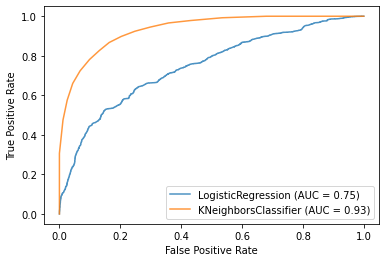

In [40]:
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

ax = plt.gca()
rlog_disp.plot(ax=ax, alpha=0.8)
Knn_disp.plot(ax=ax, alpha=0.8)
plt.show()